In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/household-power-consumption/household_power_consumption.txt


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
from scipy.stats import pearsonr

In [3]:
#import gc
#gc.collect()

In [4]:
df = pd.read_csv('../input/household-power-consumption/household_power_consumption.txt', sep = ';', header=0,
                 low_memory=False, infer_datetime_format=True,
                 parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [5]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
# point out all missing values
df.replace('?', 'nan', inplace=True) 
# make dataset numeric
df = df.astype('float32')

In [7]:
df.shape

(2075259, 7)

In [8]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [9]:
df = df.fillna(df.mean())

In [10]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
df_res = df.resample('D').sum()
print(df_res.head())

            Global_active_power  Global_reactive_power       Voltage  \
datetime                                                               
2006-12-16          1209.176025              34.922001   93552.53125   
2006-12-17          3390.459961             226.005997  345725.31250   
2006-12-18          2203.825928             161.792007  347373.62500   
2006-12-19          1666.193970             150.942001  348479.00000   
2006-12-20          2225.748047             160.998001  348923.62500   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
datetime                                                                      
2006-12-16       5180.799805             0.0           546.0          4926.0  
2006-12-17      14398.599609          2033.0          4187.0         13341.0  
2006-12-18       9247.200195          1063.0          2621.0         14018.0  
2006-12-19       7094.000000           839.0          7602.0          6197.0  
2006-12-20       9313

Text(0.5, 1.0, 'Plot of Global_active_power over time')

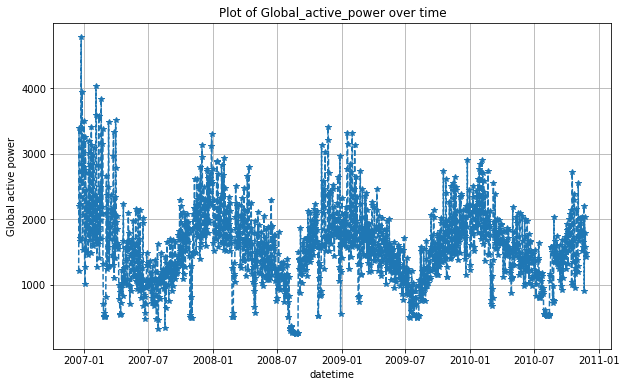

In [12]:
plt.figure(figsize=(10,6))
plt.plot(df_res.index, df_res.Global_active_power, '--', marker='*', )
plt.grid()
plt.xlabel('datetime')
plt.ylabel('Global active power')
plt.title('Plot of Global_active_power over time')

In [13]:
df_res['Voltage'].corr(df_res['Global_active_power'])

0.06239347349409072

In [14]:
df_train = df_res.iloc[:1077,:]
df_train.shape

(1077, 7)

In [15]:
df_test = df_res.iloc[1077:,:]
df_test.shape

(365, 7)

In [16]:
from fbprophet import Prophet

In [17]:
df_train.reset_index(inplace = True)
df_train.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [18]:
df_train = df_train.iloc[:,:2]             

In [19]:
df_train = df_train.rename(columns={"datetime": "ds", "Global_active_power": "y"})
df_train.head()

,ds,y
0,2006-12-16,1209.176025
1,2006-12-17,3390.459961
2,2006-12-18,2203.825928
3,2006-12-19,1666.193970
4,2006-12-20,2225.748047


In [20]:
df_test.reset_index(inplace = True)
df_test.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2009-11-27,1380.026001,133.052002,348276.68750,5704.000000,0.0,396.0,11599.0
1,2009-11-28,1858.949951,225.218002,347898.87500,7784.799805,3199.0,386.0,14350.0
2,2009-11-29,1650.962036,191.056000,350364.56250,6878.399902,1073.0,3061.0,7828.0
3,2009-11-30,1745.189941,153.382004,351020.59375,7232.200195,1080.0,361.0,12039.0
4,2009-12-01,1756.378052,141.873993,349391.75000,7312.799805,0.0,354.0,10821.0


In [21]:
df_test = df_test.iloc[:,:2]

In [22]:
df_test = df_test.rename(columns={"datetime": "ds", "Global_active_power": "y"})
df_test.head()

,ds,y
0,2009-11-27,1380.026001
1,2009-11-28,1858.949951
2,2009-11-29,1650.962036
3,2009-11-30,1745.189941
4,2009-12-01,1756.378052


In [23]:
model = Prophet()
model.fit(df_train)

Initial log joint probability = -12.802


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       2034.02    0.00092287       94.0869    1.08e-05       0.001      153  LS failed, Hessian reset 
      99       2034.07   8.47101e-05       73.4749       2.287      0.5339      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2034.09   2.33921e-05       53.3299        3.03       0.303      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       2034.09    3.1004e-06       42.8743   3.809e-08       0.001      392  LS failed, Hessian reset 
     252       2034.09   2.13813e-07       49.0727           1           1      406   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [24]:
forecast = model.predict(df_test) 
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1580.084009,1598.780315,2662.460866,1580.084009,1580.084009,519.056899,519.056899,519.056899,-64.127019,-64.127019,-64.127019,583.183918,583.183918,583.183918,0.0,0.0,0.0,2099.140908
1,2009-11-28,1580.207768,1837.074691,2990.229757,1580.207768,1580.207768,822.213567,822.213567,822.213567,245.813256,245.813256,245.813256,576.400311,576.400311,576.400311,0.0,0.0,0.0,2402.421335
2,2009-11-29,1580.331526,1806.757831,2938.128816,1580.331526,1580.331526,796.157722,796.157722,796.157722,228.519177,228.519177,228.519177,567.638545,567.638545,567.638545,0.0,0.0,0.0,2376.489248
3,2009-11-30,1580.455285,1417.367064,2530.583141,1580.455285,1580.455285,396.118617,396.118617,396.118617,-161.286790,-161.286790,-161.286790,557.405408,557.405408,557.405408,0.0,0.0,0.0,1976.573902
4,2009-12-01,1580.579043,1520.197944,2637.436635,1580.579043,1580.579043,516.895388,516.895388,516.895388,-29.332428,-29.332428,-29.332428,546.227816,546.227816,546.227816,0.0,0.0,0.0,2097.474431


In [25]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].head()
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2009-11-27,2099.140908,1598.780315,2662.460866,1580.084009,1580.084009,1580.084009
1,2009-11-28,2402.421335,1837.074691,2990.229757,1580.207768,1580.207768,1580.207768
2,2009-11-29,2376.489248,1806.757831,2938.128816,1580.331526,1580.331526,1580.331526
3,2009-11-30,1976.573902,1417.367064,2530.583141,1580.455285,1580.455285,1580.455285
4,2009-12-01,2097.474431,1520.197944,2637.436635,1580.579043,1580.579043,1580.579043


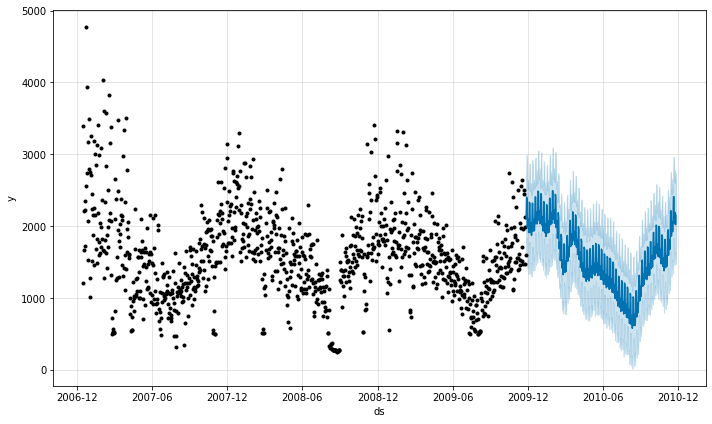

In [26]:
model.plot(forecast)
plt.show()

In [27]:
from sklearn import metrics
def Metric(y_true,y_pred):
  y_true,y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100

In [28]:
MAPE = Metric(df_test['y'],forecast['yhat'])
print(f'the Mean Average Percentage Error ( MAPE) is: {round(MAPE,2)}')

the Mean Average Percentage Error ( MAPE) is: 20.82


In [29]:
# RMSE
RMSE = np.sqrt(metrics.mean_squared_error(df_test['y'],forecast['yhat']))
RMSE
round(RMSE,2)

374.6

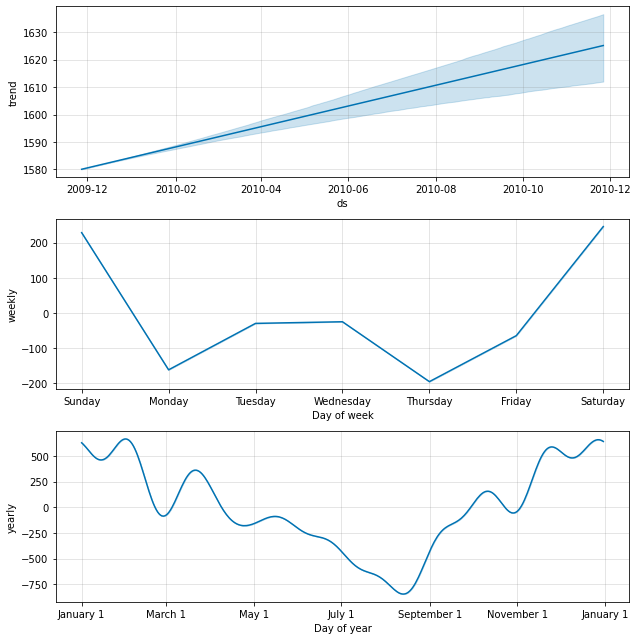

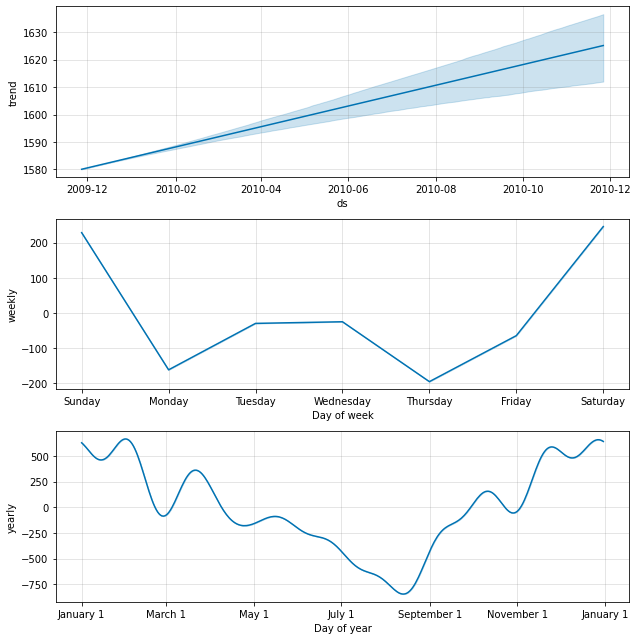

In [30]:
model.plot_components(forecast)

In [31]:
df_res.reset_index(inplace=True)
df_res.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [32]:
df_res2 = df_res.rename(columns = {'datetime':'ds','Global_active_power':'y',
                                           'Global_reactive_power':'GRP','Voltage':'V',
                                           'Global_intensity':'GI','Sub_metering_1':'SM1',
                                          'Sub_metering_2':'SM2','Sub_metering_3':'SM3'})
df_res2.head()

,ds,y,GRP,V,GI,SM1,SM2,SM3
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [33]:
train2 = df_res2.iloc[:1077,:]
test2 = df_res2.iloc[1077:,:]

In [34]:
model = Prophet(daily_seasonality=True)
model.add_regressor('GRP')
model.add_regressor('V')
model.add_regressor('GI')
model.add_regressor('SM1')
model.add_regressor('SM2')
model.add_regressor('SM3')

In [35]:
model = model.fit(train2)
forecast_2 = model.predict(test2)
forecast_2.head()

Initial log joint probability = -12.802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5734.4    0.00155503       5574.79           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5756.92   0.000159632       8815.79           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5784.29   0.000344659       5977.05      0.8271      0.8271      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5791.06   7.57676e-05       729.527           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5794.05   0.000371382       2287.16           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha   

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,GI,GI_lower,GI_upper,GRP,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1310.545634,1364.731699,1398.087145,1310.545634,1310.545634,-232.332569,-232.332569,-232.332569,7.518641,...,-0.103529,-0.103529,-0.103529,3.099835,3.099835,3.099835,0.0,0.0,0.0,1380.978427
1,2009-11-28,1310.665825,1844.983989,1878.816641,1310.665825,1310.665825,263.404254,263.404254,263.404254,-8.859759,...,1.400178,1.400178,1.400178,3.428739,3.428739,3.428739,0.0,0.0,0.0,1861.804429
2,2009-11-29,1310.786015,1630.202252,1660.005703,1310.786015,1310.786015,47.460461,47.460461,47.460461,-2.788985,...,0.144315,0.144315,0.144315,3.793334,3.793334,3.793334,0.0,0.0,0.0,1644.121664
3,2009-11-30,1310.906205,1725.969608,1758.688517,1310.906205,1310.906205,131.751041,131.751041,131.751041,3.905889,...,-0.336567,-0.336567,-0.336567,4.198325,4.198325,4.198325,0.0,0.0,0.0,1742.672564
4,2009-12-01,1311.026396,1748.278546,1779.872104,1311.026396,1311.026396,150.953373,150.953373,150.953373,5.950925,...,-1.661897,-1.661897,-1.661897,4.647592,4.647592,4.647592,0.0,0.0,0.0,1762.417732


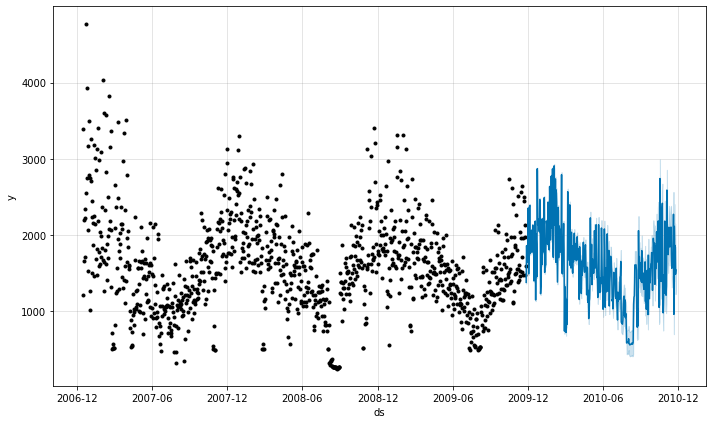

In [36]:
model.plot(forecast_2)
plt.show()

In [37]:
def Metric(y_true,y_pred):
  y_true,y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100

MAPE = Metric(test2['y'],forecast_2['yhat'])
round(MAPE,2)

2.61

In [38]:
# RMSE
RMSE = np.sqrt(metrics.mean_squared_error(test2['y'],forecast_2['yhat']))
RMSE
round(RMSE,2)

38.94

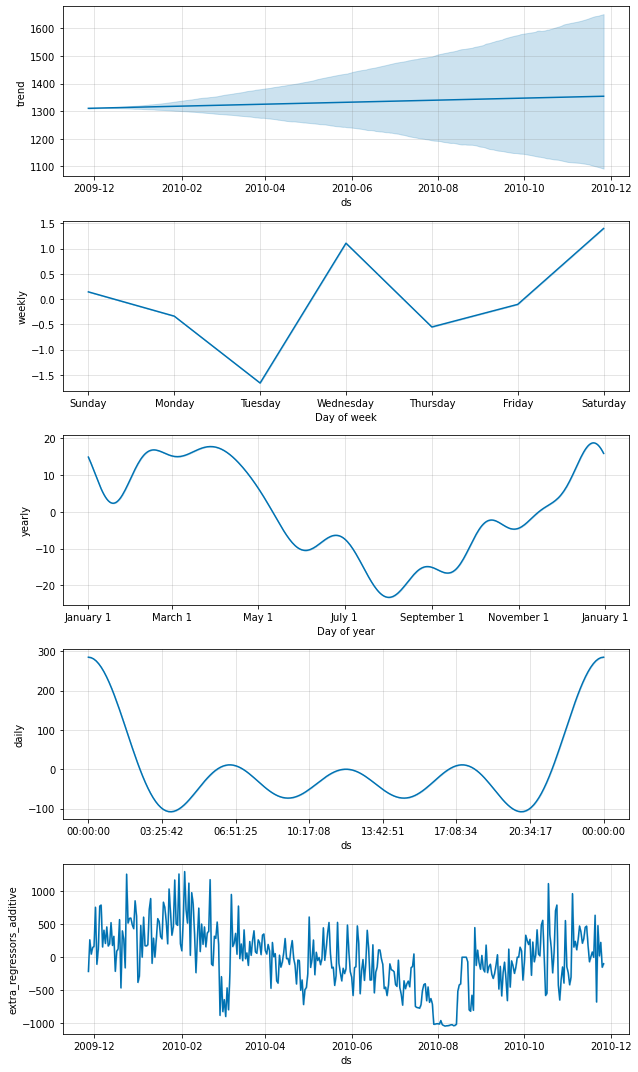

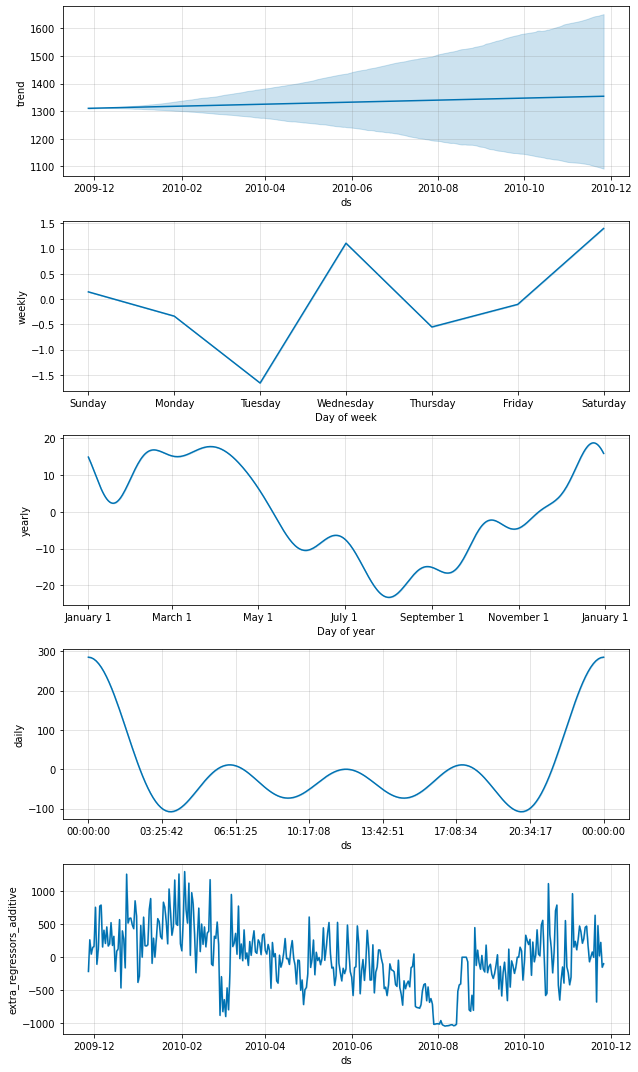

In [39]:
model.plot_components(forecast_2)